<a href="https://colab.research.google.com/github/hjwang0086/Coursera_Capstone/blob/main/IBM_Capstone_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b><u>Building Entertainment Places for Workers in CA</u></b></h1>
<i>According to <a href="https://www.ox.ac.uk/news/2019-10-24-happy-workers-are-13-more-productive">Oxford research</a>, happy workers are 13% more productive, and entertainment places provide worker happiness. Yet, it is hard to measure the happiness degree of each worker, and building entertainment places are costly. Thanks to the development of data science, however, we can approximate their happiness degree by estimating how many entertainment places are surrounded, and we can save our budgets when we only build entertainment places in some important areas. If workers are surrounded by sufficient entertainment places, they will become happier, and therefore their productivity will be enhanced. On the other hand, if they have no source of entertainment, they would become unhappy.</i>
<p>In this project, I will try to figure out which places in California may need extra entertainment places to increase productivity.<br>To do this, there are several steps:</p>
<ol>
  <li>Search information of top 100 companies in California</li>
  <li>Search their geographical locations using Geopy</li>
  <li>Search their nearby entertainment places using Foursquare API</li>
  <li>Model the happiness degree using Gaussian Mixture Model</li>
  <li>Evaluate the happiness degree for each company based on the density estimation</li>
</ol>

<h2>Step 1: Scrape information of top 100 companies in California</h2>

In [1]:
import numpy as np
import pandas as pd
import requests

from bs4 import BeautifulSoup

Scrape top-100 companies in CA

In [79]:
url = "https://www.zippia.com/advice/biggest-companies-in-california/"
html = requests.get(url).text
soup = BeautifulSoup(html, "html.parser")
table = soup.find("table")

table_contents = []
cell = {}
for idx, row in enumerate(table.findAll("td")):
  if idx % 4 == 1:
    if row.a is not None:
      cell["name"] = row.a.text
    else:
      cell["name"] = row.text
  elif idx % 4 == 2:
    cell["city"] = row.text
  elif idx % 4 == 3:
    number = int("".join(row.text.split(",")))
    cell["employees"] = number
    table_contents.append(cell)
    cell = {}

df = pd.DataFrame(table_contents)
df.head()

,name,city,employees
0,Concentrix,Fremont,225000
1,The Walt Disney Company,Burbank,201000
2,Taco Bell,Irvine,175000
3,Safeway,Pleasanton,137000
4,Gap,San Francisco,135000


In [33]:
df.shape

(100, 3)

<h2>Step 2: Search their geographical locations using Geopy</h2>

In [80]:
#!conda install -c conda-forge geopy -y
from geopy.geocoders import Nominatim

table_contents = []
for name, city, employees, in df.values:
  geolocator = Nominatim(user_agent="ny_explorer")
  location = geolocator.geocode(city+ ", CA")
  latitude, longitude = location.latitude, location.longitude
  table_contents.append({"name": name, "city": city, 
    "latitude": latitude, "longitude": longitude, "employees": employees})

df = pd.DataFrame(table_contents)
df.head()

,name,city,latitude,longitude,employees
0,Concentrix,Fremont,37.548270,-121.988572,225000
1,The Walt Disney Company,Burbank,34.181648,-118.325855,201000
2,Taco Bell,Irvine,33.685697,-117.825982,175000
3,Safeway,Pleasanton,37.662431,-121.874679,137000
4,Gap,San Francisco,37.779026,-122.419906,135000


In [50]:
df.shape

(100, 5)

Visualize through the map given their locations

In [184]:
import folium

geolocator = Nominatim(user_agent="ny_explorer")
center = geolocator.geocode("California")
latitude, longitude = location.latitude, location.longitude

map = folium.Map(location=[latitude, longitude], zoom_start=6)
for lat, lng, label in zip(df['latitude'], df['longitude'], df['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue',
      fill=True, fill_color='#3186cc', fill_opacity=0.7,
      parse_html=False).add_to(map)  
    
map

<h2>Step 3: Search their nearby entertainment places using Foursquare API</h2>

In [89]:
CLIENT_ID = 'LELW34GFXI2ZLTMKQIO0MQ53K5CUOLOPFA5UEOHZDENNFFXZ' # your Foursquare ID
CLIENT_SECRET = 'DLCWDQC4XSR1ZHMWWGGDCVA2SEUADMJT10CN41ZRS3RIOZQT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

table_contents = []
for name, city, lat, lng, _ in df.values:
  url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query=fun&limit=5'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng)
  results = requests.get(url).json()["response"]["venues"]
  
  for result in results:
    source = result["name"]
    s_lat, s_lng = result["location"]["lat"], result["location"]["lng"]
    table_contents.append({"name": name, "source": source, "latitude": s_lat, "longitude": s_lng})

df_entertain = pd.DataFrame(table_contents)
df_entertain.head()

,name,source,latitude,longitude
0,Concentrix,Fun Fun Photo Booth,37.523187,-122.001377
1,Concentrix,Fun House Theatrical Costumes,37.402079,-122.054536
2,Concentrix,Laser Nail Therapy- Largest Toenail Fungus Tre...,37.548315,-121.982717
3,Concentrix,Fun,37.649900,-121.870297
4,Concentrix,Funzo's Clownhouse,37.523416,-121.974481


In [90]:
df_entertain.shape

(495, 4)

Since there are some places without isolated from entertainment places, the shape is not (500, 4).
<br>
Now visualize through the map the again:

In [185]:
map_entertain = folium.Map(location=[latitude, longitude], zoom_start=6)
for lat, lng, label in zip(df_entertain['latitude'], df_entertain['longitude'], df_entertain['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue',
      fill=True, fill_color='#3186cc', fill_opacity=0.7,
      parse_html=False).add_to(map_entertain)  
    
map_entertain

Unlike the first map which represents the location of each company, this map represent the location of each surrounding entertainment places. We can see there are **two main groups** from this map.
<br>
Now we use Gaussian Mixture Model to make the density estimation.

<h2>Step 4: Model the happiness degree using Gaussian Mixture Model</h2>

In [96]:
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

Xs = df_entertain[["latitude", "longitude"]].values
Xs[:5]

array([[  37.5231867 , -122.0013766 ],
       [  37.402079  , -122.054536  ],
       [  37.548315  , -121.982717  ],
       [  37.64990048, -121.87029719],
       [  37.52341585, -121.97448127]])

In [97]:
gm = GaussianMixture(n_components=2, random_state=0).fit(Xs)
gm.means_

array([[  33.80370122, -117.99662773],
       [  37.64449501, -122.01055263]])

Visualize the GMM model on all the training data using <a href="https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html">this method</a>.

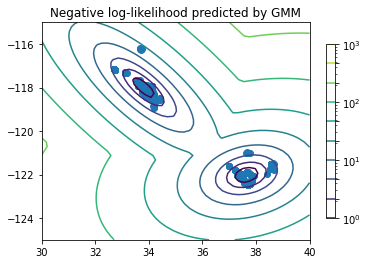

In [110]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm

x = np.linspace(30, 40)
y = np.linspace(-115., -125)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gm.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.scatter(Xs[:,0], Xs[:,1])
plt.title('Negative log-likelihood predicted by GMM')
plt.axis('tight')
plt.show()

**Such contours represent the density of entertainment places, and therefore, the degree of happiness.**
<br>
Now, based on each company's location, we can evaluate the likelihood (related to the degree of happiness) using the trained GMM model.

<h2>Step 5: Evaluate the happiness degree for each company based on the density estimation</h2>

In [170]:
table_contents = []
for name, city, lat, lng, _ in df.values:
  predict = gm.score([[lat, lng]])
  table_contents.append({"name": name, "city": city, "latitude": lat, "longitude": lng, "prediction": predict})

df_predict = pd.DataFrame(table_contents)
df_predict.head()

,name,city,latitude,longitude,prediction
0,Concentrix,Fremont,37.548270,-121.988572,-0.429192
1,The Walt Disney Company,Burbank,34.181648,-118.325855,-0.888253
2,Taco Bell,Irvine,33.685697,-117.825982,-0.567023
3,Safeway,Pleasanton,37.662431,-121.874679,-0.486446
4,Gap,San Francisco,37.779026,-122.419906,-1.466865


Now we have the table with prediction results. Use the min-max normalization to normalize the prediction score, and sort it

In [179]:
df_predict["prediction"] = (df_predict["prediction"]-df_predict["prediction"].min())/(df_predict["prediction"].max()-df_predict["prediction"].min())
df_predict = df_predict.sort_values(by=['prediction'], ascending=True)
df_predict.head()

,name,city,latitude,longitude,prediction
52,Stater Bros. Markets,San Bernardino,34.825302,-116.083314,0.000000
43,Vons,Coachella,33.686566,-116.153277,0.630059
56,Save Mart Supermarkets,Modesto,37.639097,-120.996878,0.883029
8,PORAC,Sacramento,38.581061,-121.493895,0.928773
10,State of California,Sacramento,38.581061,-121.493895,0.928773


We can see conpanies such as ***Stater Bros. Markets***, ***Vons*** and ***Save Mart Supermarkets*** have no enough entertainment places surrounded, which may have potential of higher unhappiness among their workers.
<br>
Now we visualize the prediction distribution:

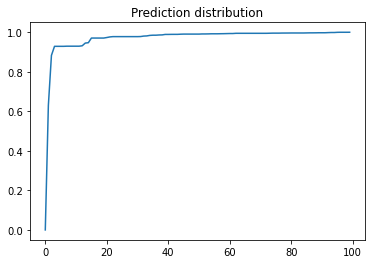

In [182]:
import matplotlib.pyplot as plt

plt.plot(range(100), df_predict["prediction"])
plt.title("Prediction distribution")
plt.show()

We can see most ***only few cases*** have little prediction values. If we only build extra entertainment places around these cases, we may ***save*** our budget and ***increase*** the average work efficiency at the same time.
<br>
Now visualize the prediction through the map again:

In [183]:
from folium.features import DivIcon

map_predict = folium.Map(location=[latitude, longitude], zoom_start=6)
for label, _, lat, lng, pred in df_predict.values:
    label = folium.Popup(label, parse_html=True)
    if pred < 0.97:
      color = "red"
    elif pred >= 0.97 and pred < 0.99:
      color = "orange"
    else:
      color = "green"
    folium.CircleMarker([lat, lng], radius=5, popup=label, color=color,
      fill=True, fill_color=color, fill_opacity=0.5,
      parse_html=False).add_to(map_predict)

map_predict

**In the map, green-colored dots represent denser entertainment places around, which may represent higher degree of happiness, and red-colored dots may represent less degree of happiness.**
<br>
For example, companies in Sacramento has less entertainment places around. Therefore, we can suggest these companies to build more entertainment places.
